<추천시스템 4강>

-협업필터링 
사용자의 구매 패턴이나 평점을 가지고 다른 사람들의 구매패턴, 평점을 통해 추천하는 방법
 
1. 최근접 이웃기반 모델

- user based collaborative filtering

사용자의 구매 패턴과 유사한 사용자를 찾아 추천 리스트 생성
-> 있는 데이터만 projection, pearson
사용자간 평점 스케일이 다르므로 이를 제거해줄 bias term 필요 
ex) 아이템마다 사용자가 매긴 점수를 스케일링 해준걸로 가중평균

단점 : user 기반 방법의 시간, 속도, 메모리가 많이 필요, 희소성(sparsity) 때문에 범위가 제한됨(많이 보는걸 주로 추천)

- item based collaborative filtering

특정 사용자가 준 점수간의 유사한 상품을 찾아서 추천 리스트 생성

2. 잠재 요인기반 협업필터링 

item space -> latent space <- user space

user,latent matrix X item,latent matrix ~~ user, item matrix  (행렬분해)

UV^t ~ R

-SGD : 고유값 분해와 같은 행렬을 대각화 하는 방법

user,latent matrix X item,latent matrix <-> user, item matrix 

둘간의 차이를 줄임, 경사하강법으로 편미분해서 업데이트하여 위 잔차를 줄이는게 목표 

오차함수에 regulization term 추가 , 값이 없는 곳은 skip

장점 : 다양한 loss function 사용가능, 딥러닝의 장점, parallelized가 가능하므로 분산처리 가능
단점 : 수렴까지 속도가 느림 -> 딥 좋은 거 쓰면 빨라짐

-ALS : SGD 가 (user,latent matrix, item,latent matrix )을 동시에 최적화하는 방법이라면, ALS는 두 행렬을 고정시키고 다른 하나의 행렬을 순차적으로 반복하면서 최적화하는 방법

-> 기존의 최적화 문제가 convex 형태가 되므로 수렴된 행렬을 찾을 수 있는 장점
(변수가 고정되므로 convex형태가 가능)

1. 초기 아이템, 사용자 행렬을 초기화 
2. 아이템 행렬 고정, 사용자 행렬 최적화 -> 정규방정식 형태로 계산됨
3. 사용자 행렬 고정, 아이템 행렬 최적화 
4. 위의 2,3 과정 반복

# SGD

In [1]:
import numpy as np
from tqdm import tqdm_notebook as tqdm

import numpy as np

In [14]:
class MatrixFactorization():
    def __init__(self, R, k, learning_rate, reg_param, epochs, verbose=False):
        """
        :param R: rating matrix
        :param k: latent parameter
        :param learning_rate: alpha on weight update
        :param reg_param: beta on weight update
        :param epochs: training epochs
        :param verbose: print status
        """
        self._R = R
        self._num_users, self._num_items = R.shape
        self._k = k
        self._learning_rate = learning_rate
        self._reg_param = reg_param
        self._epochs = epochs
        self._verbose = verbose

일단, init 함수는 Matrix Factorization이라는 클래스가 호출될 때 자동으로 실행되는 부분입니다. 파라미터로는 6개의 인자를 받는데 각각 아래의 의미를 가집니다.

R: 평점 행렬

k: User Latent와 Item Latent의 차원의 수

learning_rate: 학습률

reg_param: Weight의 Regularization 값

epochs: 전체 학습 횟수 (Total Epoch)

verbose: 학습 과정을 출력할지 여부 (True : 10번마다 cost 출력, False : cost를 출력하지 않음)

In [17]:
%%time

# rating matrix 사용자가 각 아이템에 대하여 0~5까지 몇점을 매겼는지

R = np.array([  
    [1, 0, 0, 1, 3],
    [2, 0, 3, 1, 1],
    [1, 2, 0, 5, 0],
    [1, 0, 0, 4, 4],
    [2, 1, 5, 4, 0],
    [5, 1, 5, 4, 0],
    [0, 0, 0, 1, 0],
])

factorizer = MatrixFactorization(R, k=3, learning_rate=0.01, reg_param=0.01, epochs=100, verbose=True)
factorizer.fit()

AttributeError: 'MatrixFactorization' object has no attribute 'fit'

위의 실행은 7개의 User, 5개의 Item에 대한 평점 행렬(R)에 대해서 k=3, learning_rate=0.01, reg_param=0.01, epochs=100, verbose=True 와 같은 파라미터를 가지는 MatrixFactorization 객체를 생성하라는 의미입니다. 생성된 객체에서 factorizer.fit()을 통해서 fit() 함수를 실행하면, 아래의 코드가 실행되게 됩니다

In [16]:
def fit(self):
    """
    training Matrix Factorization : Update matrix latent weight and bias

    참고: self._b에 대한 설명
    - global bias: input R에서 평가가 매겨진 rating의 평균값을 global bias로 사용
    - 정규화 기능. 최종 rating에 음수가 들어가는 것 대신 latent feature에 음수가 포함되도록 해줌.

    :return: training_process
    """

    # init latent features
    self._P = np.random.normal(size=(self._num_users, self._k))# 유저에 대한 latent space
    self._Q = np.random.normal(size=(self._num_items, self._k))# 아이템에 대한 latent space

    # init biases
    self._b_P = np.zeros(self._num_users)
    self._b_Q = np.zeros(self._num_items)
    self._b = np.mean(self._R[np.where(self._R != 0)])

    # train while epochs
    self._training_process = []
    for epoch in range(self._epochs):
        # rating이 존재하는 index를 기준으로 training
        xi, yi = self._R.nonzero()
        for i, j in zip(xi, yi):
            self.gradient_descent(i, j, self._R[i, j])
        cost = self.cost()
        self._training_process.append((epoch, cost))

        
        # print status
        if self._verbose == True and ((epoch + 1) % 10 == 0):
            print("Iteration: %d ; cost = %.4f" % (epoch + 1, cost))


fit 함수에서 가장 먼저 실행되는 부분은 아래의 Latent Matrix를 초기화해주는 부분입니다.

In [3]:
# init latent features
self._P = np.random.normal(size=(self._num_users, self._k))
self._Q = np.random.normal(size=(self._num_items, self._k))

# init biases
self._b_P = np.zeros(self._num_users)
self._b_Q = np.zeros(self._num_items)
self._b = np.mean(self._R[np.where(self._R != 0)])

NameError: name 'self' is not defined

이때, np.random.normal 함수를 이용해서 행렬을 초기화해주고 np.zeros 함수를 이용해서 bias 부분을 초기화해줍니다. 함수의 의미는 아래와 같습니다.

np.random.normal : (self._num_users, self._k)의 크기로 행렬을 정규분포 형태로 초기화합니다. 위의 예시에서는 User Latent Matrix는 (7, 3)의 크기를 Item Latent Matrix는 (5, 3)의 크기를 가짐

np.zeros : self._num_users 혹은 self._num_items의 크기만큼의 0 값을 가지는 벡터를 생성합니다.
np.mean(self._R[np.where(self._R != 0)]) : 전체 평점의 평균을 계산
이후, 전체 학습 과정을 진행합니다.

In [ ]:
# train while epochs
self._training_process = []
for epoch in range(self._epochs):
    # rating이 존재하는 index를 기준으로 training
    xi, yi = self._R.nonzero()
    for i, j in zip(xi, yi):
        self.gradient_descent(i, j, self._R[i, j])
    cost = self.cost()
    self._training_process.append((epoch, cost))

    # print status
    if self._verbose == True and ((epoch + 1) % 10 == 0):
        print("Iteration: %d ; cost = %.4f" % (epoch + 1, cost))


self._training_process = [] 는 for문 안의 self._training_process.append((epoch, cost)) 에 사용되는 부분으로 학습 시에 Epoch와 Cost를 저장하는 부분입니다. for문의 경우 처음 파라미터로 받은 self._epochs 만큼 반복학습을 진행하게 됩니다.

먼저 시행되는 for문의 첫 번째로 시행되는 xi, yi = self._R.nonzero()는 평점 행렬에서 0이 아닌 부분 즉, 사용자가 평점을 매긴 부분에 대해서만 값을 추출하라는 의미입니다. 그 이유는 위의 이론에서 말했듯이 결측치가 아닌 부분을 통해서만 학습을 진행하려는 의도입니다. 이후에 해당 부분을 통해서 모든 평점 부분에 대해서 gradient_descent를 실행해줍니다

In [5]:
for i, j in zip(xi, yi):
    self.gradient_descent(i, j, self._R[i, j])

NameError: name 'xi' is not defined

In [6]:
def gradient_descent(self, i, j, rating):
    """
    graident descent function

    :param i: user index of matrix
    :param j: item index of matrix
    :param rating: rating of (i,j)
    """

    # get error
    prediction = self.get_prediction(i, j)
    error = rating - prediction

    # update biases
    self._b_P[i] += self._learning_rate * (error - self._reg_param * self._b_P[i])
    self._b_Q[j] += self._learning_rate * (error - self._reg_param * self._b_Q[j])

    # update latent feature
    dp, dq = self.gradient(error, i, j)
    self._P[i, :] += self._learning_rate * dp
    self._Q[j, :] += self._learning_rate * dq

gradient_descent 함수의 경우 행렬의 원소 위치(i, j)와 평점 값(self._R[i, j])을 받습니다. 바로 시작하는 prediction = self.get_prediction(i, j) 은 User Latent Matrix와 Item Latent Matrix의 곱을 통해서 평점 행렬의 값들을 생성하는 부분입니다.

self._P[i, :].dot(self._Q[j, :].T) 에서 User Latent P와 Item Latent Q가 곱해져서 평점을 계산하고 Bias를 없애기 위해서 전체 평균(self._b), User의 평균 평점(self._b_P[i]), Item의 평균 평점(self._b_Q[j])을 더해줌으로써 값을 생성합니다.

In [7]:
def get_prediction(self, i, j):
    """
    get predicted rating: user_i, item_j
    :return: prediction of r_ij
    """
    return self._b + self._b_P[i] + self._b_Q[j] + self._P[i, :].dot(self._Q[j, :].T)

이후에, error = rating - prediction 을 통해서 얼마만큼의 차이가 있는지 계산을 합니다. 그리고 아래의 수식에서 사용한 공식을 이용해서 self.gradient(error, i, j) 에서 Gradient 값을 계산하고 Weight 및 Bais를 업데이트합니다.

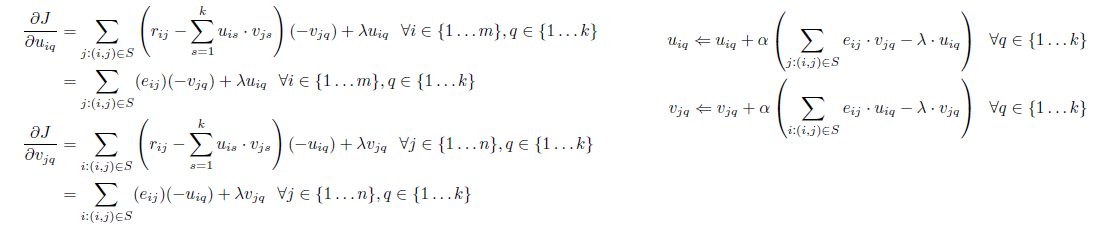


In [8]:
# update biases
self._b_P[i] += self._learning_rate * (error - self._reg_param * self._b_P[i])
self._b_Q[j] += self._learning_rate * (error - self._reg_param * self._b_Q[j])

# update latent feature
dp, dq = self.gradient(error, i, j)
self._P[i, :] += self._learning_rate * dp
self._Q[j, :] += self._learning_rate * dq

NameError: name 'self' is not defined

이후에, cost = self.cost() 에서 전체 Matrix에 대해서 오차를 계산하고 출력해줍니다. cost += pow(self._R[x, y] - self.get_prediction(x, y), 2) 에서 각 평점 별로 오차를 계산하게 됩니다.

In [9]:
def cost(self):
    """
    compute root mean square error
    :return: rmse cost
    """

    # xi, yi: R[xi, yi]는 nonzero인 value를 의미한다.
    # 참고: http://codepractice.tistory.com/90
    xi, yi = self._R.nonzero()
    # predicted = self.get_complete_matrix()
    cost = 0
    for x, y in zip(xi, yi):
        cost += pow(self._R[x, y] - self.get_prediction(x, y), 2)
    return np.sqrt(cost/len(xi))

이후, 모든 Epoch에 대해서 학습이 완료되면 factorizer.get_complete_matrix() 를 통해서 완성된 평점 행렬을 추출하게 되면 SGD를 이용한 협업 필터링이 완료되게 됩니다

In [10]:
factorizer.get_complete_matrix()

NameError: name 'factorizer' is not defined

# 최종 SGD코드

Base code : https://yamalab.tistory.com/92

In [18]:
import numpy as np
from tqdm import tqdm_notebook as tqdm

import numpy as np

# Base code : https://yamalab.tistory.com/92
class MatrixFactorization():
    def __init__(self, R, k, learning_rate, reg_param, epochs, verbose=False):
        """
        :param R: rating matrix
        :param k: latent parameter
        :param learning_rate: alpha on weight update
        :param reg_param: beta on weight update
        :param epochs: training epochs
        :param verbose: print status
        """
        self._R = R
        self._num_users, self._num_items = R.shape
        self._k = k
        self._learning_rate = learning_rate
        self._reg_param = reg_param
        self._epochs = epochs
        self._verbose = verbose


    def fit(self):
        """
        training Matrix Factorization : Update matrix latent weight and bias

        참고: self._b에 대한 설명
        - global bias: input R에서 평가가 매겨진 rating의 평균값을 global bias로 사용
        - 정규화 기능. 최종 rating에 음수가 들어가는 것 대신 latent feature에 음수가 포함되도록 해줌.

        :return: training_process
        """

        # init latent features
        self._P = np.random.normal(size=(self._num_users, self._k))
        self._Q = np.random.normal(size=(self._num_items, self._k))

        # init biases
        self._b_P = np.zeros(self._num_users)
        self._b_Q = np.zeros(self._num_items)
        self._b = np.mean(self._R[np.where(self._R != 0)])

        # train while epochs
        self._training_process = []
        for epoch in range(self._epochs):
            # rating이 존재하는 index를 기준으로 training
            xi, yi = self._R.nonzero()
            for i, j in zip(xi, yi):
                self.gradient_descent(i, j, self._R[i, j])
            cost = self.cost()
            self._training_process.append((epoch, cost))

            # print status
            if self._verbose == True and ((epoch + 1) % 10 == 0):
                print("Iteration: %d ; cost = %.4f" % (epoch + 1, cost))


    def cost(self):
        """
        compute root mean square error
        :return: rmse cost
        """

        # xi, yi: R[xi, yi]는 nonzero인 value를 의미한다.
        # 참고: http://codepractice.tistory.com/90
        xi, yi = self._R.nonzero()
        # predicted = self.get_complete_matrix()
        cost = 0
        for x, y in zip(xi, yi):
            cost += pow(self._R[x, y] - self.get_prediction(x, y), 2)
        return np.sqrt(cost/len(xi))


    def gradient(self, error, i, j):
        """
        gradient of latent feature for GD

        :param error: rating - prediction error
        :param i: user index
        :param j: item index
        :return: gradient of latent feature tuple
        """

        dp = (error * self._Q[j, :]) - (self._reg_param * self._P[i, :])
        dq = (error * self._P[i, :]) - (self._reg_param * self._Q[j, :])
        return dp, dq


    def gradient_descent(self, i, j, rating):
        """
        graident descent function

        :param i: user index of matrix
        :param j: item index of matrix
        :param rating: rating of (i,j)
        """

        # get error
        prediction = self.get_prediction(i, j)
        error = rating - prediction

        # update biases
        self._b_P[i] += self._learning_rate * (error - self._reg_param * self._b_P[i])
        self._b_Q[j] += self._learning_rate * (error - self._reg_param * self._b_Q[j])

        # update latent feature
        dp, dq = self.gradient(error, i, j)
        self._P[i, :] += self._learning_rate * dp
        self._Q[j, :] += self._learning_rate * dq


    def get_prediction(self, i, j):
        """
        get predicted rating: user_i, item_j
        :return: prediction of r_ij
        """
        return self._b + self._b_P[i] + self._b_Q[j] + self._P[i, :].dot(self._Q[j, :].T)


    def get_complete_matrix(self):
        """
        computer complete matrix PXQ + P.bias + Q.bias + global bias

        - PXQ 행렬에 b_P[:, np.newaxis]를 더하는 것은 각 열마다 bias를 더해주는 것
        - b_Q[np.newaxis:, ]를 더하는 것은 각 행마다 bias를 더해주는 것
        - b를 더하는 것은 각 element마다 bias를 더해주는 것

        - newaxis: 차원을 추가해줌. 1차원인 Latent들로 2차원의 R에 행/열 단위 연산을 해주기위해 차원을 추가하는 것.

        :return: complete matrix R^
        """
        return self._b + self._b_P[:, np.newaxis] + self._b_Q[np.newaxis:, ] + self._P.dot(self._Q.T)



# run example
if __name__ == "__main__":
    # rating matrix - User X Item : (7 X 5)
    R = np.array([
        [1, 0, 0, 1, 3],
        [2, 0, 3, 1, 1],
        [1, 2, 0, 5, 0],
        [1, 0, 0, 4, 4],
        [2, 1, 5, 4, 0],
        [5, 1, 5, 4, 0],
        [0, 0, 0, 1, 0],
    ])

    # P, Q is (7 X k), (k X 5) matrix

In [19]:
%%time
factorizer = MatrixFactorization(R, k=3, learning_rate=0.01, reg_param=0.01, epochs=100, verbose=True)
factorizer.fit()

Iteration: 10 ; cost = 1.2918
Iteration: 20 ; cost = 1.0238
Iteration: 30 ; cost = 0.8821
Iteration: 40 ; cost = 0.7836
Iteration: 50 ; cost = 0.6986
Iteration: 60 ; cost = 0.6124
Iteration: 70 ; cost = 0.5202
Iteration: 80 ; cost = 0.4258
Iteration: 90 ; cost = 0.3378
Iteration: 100 ; cost = 0.2635
Wall time: 112 ms


In [20]:
factorizer.get_complete_matrix()

array([[0.81011901, 4.52737719, 3.10803623, 1.4929215 , 3.05795141],
       [1.77799887, 1.85679211, 2.68940765, 1.53252891, 1.20347901],
       [1.16024582, 1.95425853, 5.57169709, 4.63305448, 1.17458948],
       [1.28443091, 4.67666969, 4.83747529, 3.40060878, 3.82262274],
       [1.92938296, 1.01509157, 4.95048365, 4.1731606 , 2.19903465],
       [4.91620589, 1.06106323, 4.81398149, 4.20304544, 1.68462986],
       [2.79448834, 2.65551219, 2.13699546, 0.87317818, 2.75189749]])